In [51]:
# Packages to import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f
import plotly.express as px
import plotly.graph_objects as go
import brokenaxes
from sklearn.linear_model import LinearRegression

# run the following line to install brokenaxes in the runtime
# !pip install brokenaxes

# Question 1

In [36]:
# --- GENERAL GRAPHICAL SETTINGS ---
# Define the colors
colors = ['#0000FF', '#A52A2A', '#008080', '#FF00FF', '#800080', '#FFA500', '#278727', '#FF0000']

# Define a list of linestyles to alternate
linestyles = ['-', ':', '-.', ':', '-.', '--', ':', '-']
linewidths = [2.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 2.5]

In [62]:
# --- MODEL AND PARAMETERS ---
np.random.seed(123)

N = 100
k = 10
a_list = [.5, .4, .3, .2, .15, .1, .05, 0]
rho_list = [0, .1, .2, .3, .4, .5, .6, .7, .9, .95]

# Define the Z's
# to keep fixed throughout the experiment
np.random.seed(123)
Z = np.random.randn(N, k) # draw from a standardn normal

# Define the model with a function
def model(Z, rho, a, beta=0):
  # generate errors
  sigma = [[1, rho], [rho, 1]]
  eps, v = np.random.multivariate_normal([0, 0], sigma, N).T

  # define pi
  pi = a * np.array([1] + [0] * 9)

  # generate X
  X = Z @ pi + v

  # generate y
  y = beta * X + eps

  return y, X

# Define the 2SLS estimation
def two_sls(y, X, Z):
  # first stage
  pi_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ X
  P_z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T # projection matrix of Z

  # second stage
  X_proj = X.T @ P_z @ X
  beta_hat = X.T @ P_z @ y / X_proj

  # compute standard error for 2SLS
  res = y - X * beta_hat # residuals
  s2 = (res.T @ res)/(N-1)
  s_err = np.sqrt(s2 / X_proj)

  # calculate t-statistic
  t_stat = beta_hat / s_err

  return beta_hat, t_stat

# Define the critical values for the t-test
alpha = 0.05
cv_upper = stats.t.ppf(1-alpha/2, N-1)
cv_lower = stats.t.ppf(alpha/2, N-1)

# Define the t test
def t_test(a, rho, Z, cv_upper, cv_lower, simulations):
  # initialize rejection counter
  reject_count = 0

  # start simulations
  for i in range(simulations):
    y, X = model(Z, rho, a) # generate dgp
    t_stat = two_sls(y, X, Z)[1] # estimate the model
    if t_stat < cv_lower or t_stat > cv_upper:
        reject_count += 1

  # Compute the rejection frequency
  reject_freq = reject_count / simulations

  return reject_freq

In [63]:
# --- MONTECARLO SIMULATION ---
np.random.seed(123)

# Initialize DataFrame to store results
df = pd.DataFrame(np.zeros((len(a_list), len(rho_list))), index = a_list, columns = rho_list)

# Define number of simulations
rep = 5000

# Calculate rejection frequency for each value of a, as a function of rho
for i,a in enumerate(a_list):
  np.random.seed(123) # start each simulation run with the same seed
  for j,rho in enumerate(rho_list): # run t test as a function of rho
    df.iloc[i,j] = t_test(a, rho, Z, cv_upper, cv_lower, simulations=rep)

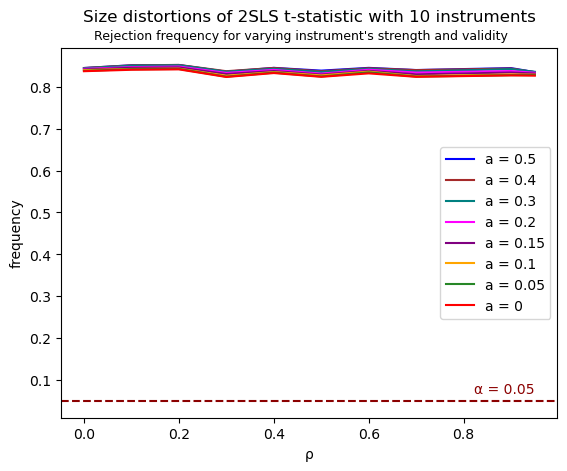

In [61]:
# --- GRAPHICAL OUTPUT ---

# Plot rejection frequency as a function of rho for each a
for i,a in enumerate(a_list):
  plt.plot(rho_list, df.iloc[i,:], label=f'a = {a}', color=colors[i])

# Add 5% line
plt.axhline(y=0.05, color='darkred', linestyle='--')

# Add the label with alpha above the red dashed line
plt.text(x=max(rho_list), y=0.06, s='α = 0.05', color='darkred', ha='right', va='bottom')

# Add labels, legend, and title
plt.xlabel('ρ')
plt.ylabel('frequency')
plt.legend()
plt.title("Size distortions of 2SLS t-statistic with 10 instruments", y=1.05)
plt.suptitle("Rejection frequency for varying instrument's strength and validity", fontsize=9, y=.92)

# Export the plot as a png image with high dpi
plt.savefig('figure 1.png', dpi=900)

# Display the plot
plt.show()

In [8]:
# Debugging cell
print(rho_list)

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 0.95]


# Question 2

In [9]:
# --- MODEL AND PARAMETERS (APPROACH 2) ---
# this approach gets rid of simulation error
np.random.seed(123)

# Define the parameters
k = 10

r_list = np.arange(500) # grid for values for r(beta_0)
S = 10000 # number of simulations

# Define function to compute critical values from LR statistic
def cv_lr(r_list, S, k):

  # initialize array to store results
  G = len(r_list)
  lr_critical_values = np.zeros(G)

  for i,r in enumerate(r_list):
    np.random.seed(123) # reset the seed for each simulation run
    LR = np.zeros(S) # initialize array to store LR statistics

    for s in range(S):
      # simulate psi functions
      psi_1 = np.random.chisquare(1)
      psi_k_min1 = np.random.chisquare(k-1)
      # compute the LR statistic
      LR[s] = 0.5 * (psi_k_min1 + psi_1 - r + np.sqrt((psi_k_min1 + psi_1 + r)**2 - 4 * r * psi_k_min1))

    # compute the critical values for each r(beta_0)
    lr_critical_values[i] = np.quantile(LR, 0.95)

  return lr_critical_values

In [10]:
# --- COMPUTATION ---
np.random.seed(123)
lr_cv = cv_lr(r_list, S, k=10)

In [11]:
# Printing first and last critical values
print(f'{lr_cv[0]:.3f}', f'{lr_cv[-1]:.3f}')

18.270 3.897


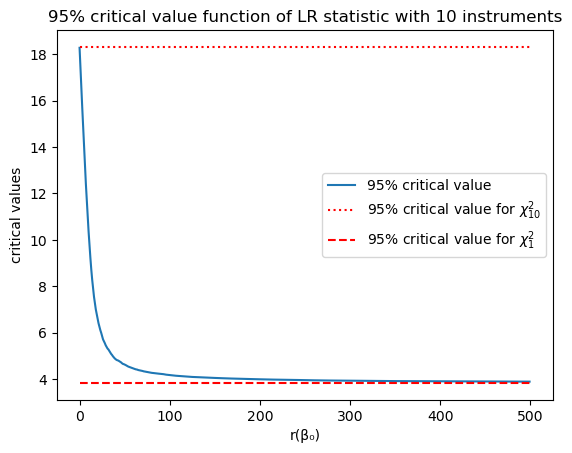

In [12]:
# --- GRAPHICAL OUTPUT ---

plt.plot(r_list, lr_cv, label='95% critical value')  # Main line plot
plt.hlines(stats.chi2(10).ppf(0.95), 0, len(r_list), linestyles='dotted', color = 'red', label=r"95% critical value for $\chi^2_{10}$")  # Horizontal line for Chi2(10)
plt.hlines(stats.chi2(1).ppf(0.95), 0, len(r_list), linestyles='dashed', color = 'red', label=r"95% critical value for $\chi^2_{1}$")  # Horizontal line for Chi2(1)

plt.xlabel('r(β₀)')  # X-axis label
plt.ylabel('critical values')  # Y-axis label
plt.title('95% critical value function of LR statistic with 10 instruments')  # Title
plt.legend(loc='right')  # Show legend

# Export the plot as a png image with high dpi
plt.savefig('figure 2.png', dpi=800)

plt.show()  # Display the plot

In [13]:
# Debugging cell
LR = cv_lr(r_list, S, k)
print(np.shape(LR))
CV = np.quantile(LR, 0.95, axis=0)
print(np.shape(CV))

(500,)
()


# Question 3

In [42]:
# --- AR: MODEL AND PARAMETERS ---
np.random.seed(123)
k = 10

# critical value of the chi^2 * 1/k distribution
alpha = 0.05
cv_ar = stats.chi2.ppf(1-alpha, k) / k

# Define the AR statistic
def anderson_rubin(a, rho, Z, cv_ar, simulations, k, beta_0=0):
    N = Z.shape[0]
    k = Z.shape[1]

    # initialize rejection counter
    reject_count = 0

    # start simulations
    for i in range(simulations):
      y, X = model(Z, rho, a) # generate dgp
      num = (y - X*beta_0).T @ (Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ (y - X*beta_0) / k
      den = (y - X*beta_0).T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ (y - X*beta_0) / (N - k)
      AR_stat = num / den
      if AR_stat > cv_ar:
        reject_count += 1

    # Compute the rejection frequency
    reject_freq = reject_count / simulations

    return reject_freq

In [43]:
# --- AR: MONTECARLO SIMULATION ---
np.random.seed(123)

# Initialize DataFrame to store results
df_ar = pd.DataFrame(np.zeros((len(a_list), len(rho_list))), index = a_list, columns = rho_list)

# Define number of simulations
rep = 5000

# Calculate rejection frequency for each value of a, as a function of rho
for i,a in enumerate(a_list):
  np.random.seed(123) # start each simulation run with the same seed
  for j,rho in enumerate(rho_list): # run t test as a function of rho
    df_ar.iloc[i,j] = anderson_rubin(a, rho, Z, cv_ar, simulations=rep, k=k)

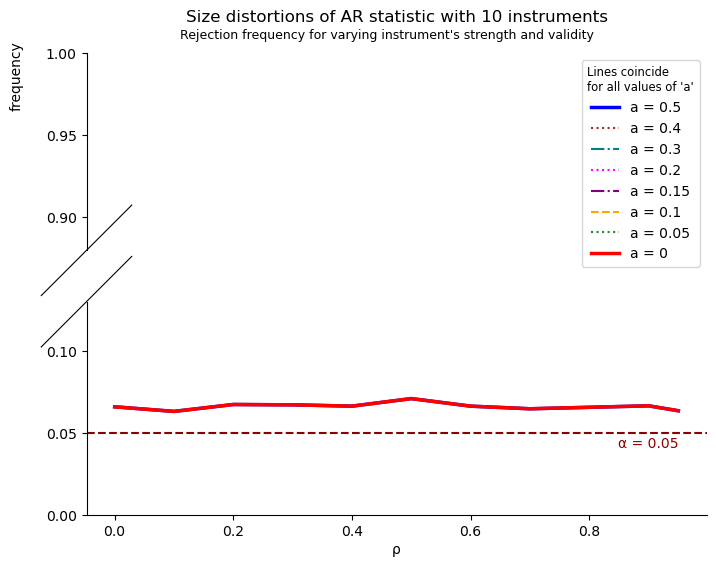

In [44]:
# --- AR: GRAPHICAL OUTPUT ---

# Create a broken axis plot
fig = plt.figure(figsize=(8, 6))
bax = brokenaxes.brokenaxes(ylims=((0, 0.13), (0.88, 1.0)), hspace=.25, d=0.08)

# Plot rejection frequency as a function of rho for each a
for i, a in enumerate(a_list):
  bax.plot(rho_list, df_ar.iloc[i, :], label=f'a = {a}', linestyle=linestyles[i % len(linestyles)], linewidth=linewidths[i % len(linestyles)], color=colors[i % len(colors)])

# Add 5% line
bax.axhline(y=0.05, color='darkred', linestyle='--')

# Add the label with alpha above the red dashed line
bax.text(x=max(rho_list), y=0.039, s='α = 0.05', color='darkred', ha='right', va='bottom')

# Add labels, legend, and title
bax.set_xlabel('ρ', labelpad=20)
bax.set_ylabel('frequency', y =0.95,
               # make it more distant from the vertical axis
                labelpad=45)
bax.axs[0].set_yticks([0.90, 0.95, 1.00]) # set the ticks for the vertical axis
bax.axs[1].set_yticks([0.00, 0.05, 0.10]) # set the ticks for the vertical axis

bax.legend(loc='upper right')
# Set a legend title
bax.legend(title="Lines coincide \nfor all values of 'a'", title_fontsize='small', loc='upper right')


bax.set_title("Size distortions of AR statistic with 10 instruments", y=1.05)
fig.suptitle("Rejection frequency for varying instrument's strength and validity", fontsize=9, y=.92)

# Export the plot as a png image with high dpi
plt.savefig('figure 3a.png', dpi=800)

# Display the plot
plt.show()

In [45]:
# --- SCORE STATISTIC: MODEL AND PARAMETERS ---
np.random.seed(123)
k = 10

# critical value of the chi^2 distribution with 1 dof
alpha = 0.05
cv_score = stats.chi2.ppf(1-alpha, 1)

# Define the score statistic
def score_test(a, rho, Z, cv_score, simulations, k, beta_0=0):
    N = Z.shape[0]
    k = Z.shape[1]

    # initialize rejection counter
    reject_count = 0

    # start simulations-
    for i in range(simulations):
      y, X = model(Z, rho, a) # generate dgp
      eps = y - X*beta_0
      sigma_hat_eV = 1/(N-k) * eps.T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ X   # slide 61
      sigma_hat_ee = 1/(N-k) * eps.T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @Z.T) @ eps
      rho_hat = sigma_hat_eV / sigma_hat_ee
      pi_tilde = np.linalg.inv(Z.T@Z) @ Z.T @ (X - eps * rho_hat) # estimator for pi
      proj_matrix_Z_pi = (Z @ pi_tilde).reshape(N, -1) @ np.linalg.inv((pi_tilde.T @ Z.T).reshape(-1, N) @ (Z @ pi_tilde).reshape(N, -1)) @ (pi_tilde.T @ Z.T).reshape(-1, N)
      score_stat = (1/sigma_hat_ee) * eps.T @ proj_matrix_Z_pi @ eps
      if score_stat > cv_score:
        reject_count += 1

    # Compute the rejection frequency
    reject_freq = reject_count / simulations

    return reject_freq

In [18]:
# --- SCORE: MONTECARLO SIMULATION ---
np.random.seed(123)

# Initialize DataFrame to store results
df_score = pd.DataFrame(np.zeros((len(a_list), len(rho_list))), index = a_list, columns = rho_list)

# Define number of simulations
rep = 5000

# Calculate rejection frequency for each value of a, as a function of rho
for i,a in enumerate(a_list):
  np.random.seed(123) # start each simulation run with the same seed
  for j,rho in enumerate(rho_list): # run t test as a function of rho
    df_score.iloc[i,j] = score_test(a, rho, Z, cv_score, simulations=rep, k=k)

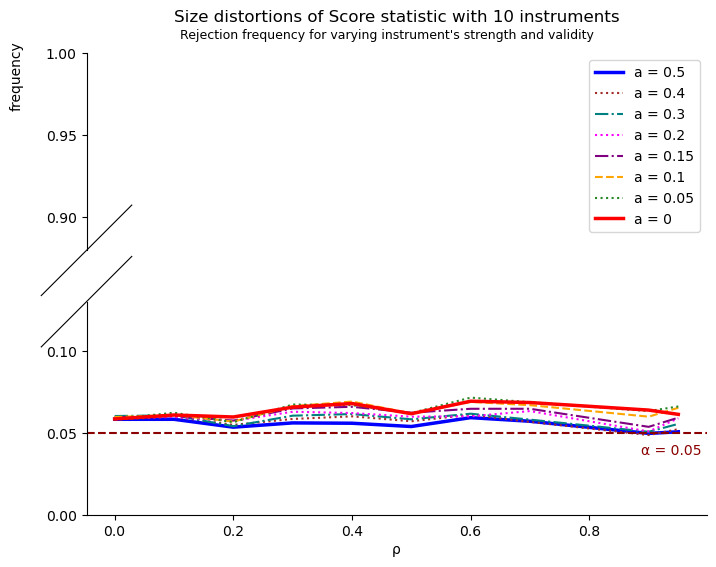

In [47]:
# --- SCORE: GRAPHICAL OUTPUT ---

# Create a broken axis plot
fig = plt.figure(figsize=(8, 6))
bax = brokenaxes.brokenaxes(ylims=((0, 0.13), (0.88, 1.0)), hspace=.25, d=0.08)

# Plot rejection frequency as a function of rho for each a
for i, a in enumerate(a_list):
  bax.plot(rho_list, df_score.iloc[i, :], label=f'a = {a}', linestyle=linestyles[i % len(linestyles)], linewidth=linewidths[i % len(linestyles)], color=colors[i % len(colors)])

# Add 5% line
bax.axhline(y=0.05, color='darkred', linestyle='--')

# Add the label with alpha above the red dashed line
bax.text(x=0.99, y=0.035, s='α = 0.05', color='darkred', ha='right', va='bottom')

# Add labels, legend, and title
bax.set_xlabel('ρ', labelpad=20)
bax.set_ylabel('frequency', y =0.95,
               # make it more distant from the vertical axis
                labelpad=45)
bax.axs[0].set_yticks([0.90, 0.95, 1.00]) # set the ticks for the vertical axis
bax.axs[1].set_yticks([0.00, 0.05, 0.10]) # set the ticks for the vertical axis

bax.legend(loc='upper right')

bax.set_title("Size distortions of Score statistic with 10 instruments", y=1.05)
fig.suptitle("Rejection frequency for varying instrument's strength and validity", fontsize=9, y=.92)

# Export the plot as a png image with high dpi
plt.savefig('figure 3b.png', dpi=900)

# Display the plot
plt.show()

In [20]:
# --- LR STATISTIC: MODEL AND PARAMETERS ---
np.random.seed(123)
k = 10

# Define the score statistic
def lr_test(a, rho, Z, simulations, k, beta_0=0):
    N = Z.shape[0]
    k = Z.shape[1]

    # initialize rejection counter
    reject_count = 0

    # start simulations-
    for i in range(simulations):
      y, X = model(Z, rho, a) # generate dgp

      # compute AR statistic
      num_ar = (y - X*beta_0).T @ (Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ (y - X*beta_0) / k
      den_ar = (y - X*beta_0).T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ (y - X*beta_0) / (N - k)
      AR_stat = num_ar / den_ar

      # compute score statistic
      eps = y - X*beta_0
      sigma_hat_eV = 1/(N-k) * eps.T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ X   # slide 61
      sigma_hat_ee = 1/(N-k) * eps.T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @Z.T) @ eps
      rho_hat = sigma_hat_eV / sigma_hat_ee
      pi_tilde = np.linalg.inv(Z.T@Z) @ Z.T @ (X - eps * rho_hat) # estimator for pi
      proj_matrix_Z_pi = (Z @ pi_tilde).reshape(N, -1) @ np.linalg.inv((pi_tilde.T @ Z.T).reshape(-1, N) @ (Z @ pi_tilde).reshape(N, -1)) @ (pi_tilde.T @ Z.T).reshape(-1, N)
      score_stat = (1/sigma_hat_ee) * eps.T @ proj_matrix_Z_pi @ eps

      # compute r(beta_0)
      sigma_hat_Ve = 1/(N-k) * X.T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ eps
      sigma_hat_VV = 1/(N-k) * X.T @ (np.eye(N) - Z @ np.linalg.inv(Z.T@Z) @ Z.T) @ X
      sigma_hat_VV_e = sigma_hat_VV - (sigma_hat_Ve * sigma_hat_eV) / sigma_hat_ee
      r = 1/sigma_hat_VV_e * pi_tilde.T @ Z.T @ Z @ pi_tilde

      # compute LR statistic
      LR_stat = 0.5 * (k*AR_stat - r + np.sqrt((k*AR_stat + r)**2 - 4*r * (k*AR_stat - score_stat)))

      # obtain the critical value
      # obtain the index of the integer between 0 and 500 that is closest to r
      r_index = np.argmin(np.abs(r_list - r))
      # obtain the critical value corresponding to the index of this number
      cv_lr = lr_cv[r_index]

      if LR_stat > cv_lr:
        reject_count += 1

    # Compute the rejection frequency
    reject_freq = reject_count / simulations

    return reject_freq

In [21]:
# --- LR: MONTECARLO SIMULATION ---
np.random.seed(123)

# Initialize DataFrame to store results
df_lr = pd.DataFrame(np.zeros((len(a_list), len(rho_list))), index = a_list, columns = rho_list)

# Define number of simulations
rep = 5000

# Calculate rejection frequency for each value of a, as a function of rho
for i,a in enumerate(a_list):
  np.random.seed(123) # start each simulation run with the same seed
  for j,rho in enumerate(rho_list): # run t test as a function of rho
    df_lr.iloc[i,j] = lr_test(a, rho, Z, simulations=rep, k=k)

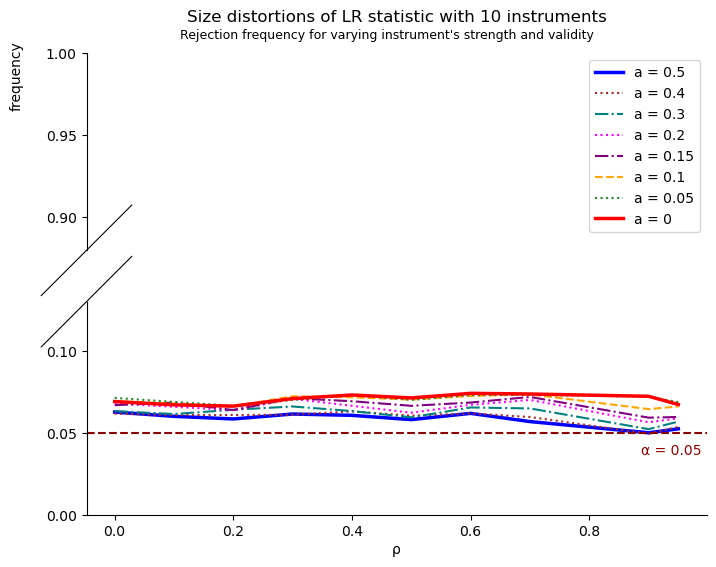

In [48]:
# --- SCORE: GRAPHICAL OUTPUT ---

# Create a broken axis plot
fig = plt.figure(figsize=(8, 6))
bax = brokenaxes.brokenaxes(ylims=((0, 0.13), (0.88, 1.0)), hspace=.25, d=0.08)

# Plot rejection frequency as a function of rho for each a
for i, a in enumerate(a_list):
  bax.plot(rho_list, df_lr.iloc[i, :], label=f'a = {a}', linestyle=linestyles[i % len(linestyles)], linewidth=linewidths[i % len(linestyles)], color=colors[i % len(colors)])

# Add 5% line
bax.axhline(y=0.05, color='darkred', linestyle='--')

# Add the label with alpha above the red dashed line
bax.text(x=0.99, y=0.035, s='α = 0.05', color='darkred', ha='right', va='bottom')

# Add labels, legend, and title
bax.set_xlabel('ρ', labelpad=20)
bax.set_ylabel('frequency', y =0.95,
               # make it more distant from the vertical axis
                labelpad=45)
bax.axs[0].set_yticks([0.90, 0.95, 1.00]) # set the ticks for the vertical axis
bax.axs[1].set_yticks([0.00, 0.05, 0.10]) # set the ticks for the vertical axis

bax.legend(loc='upper right')

bax.set_title("Size distortions of LR statistic with 10 instruments", y=1.05)
fig.suptitle("Rejection frequency for varying instrument's strength and validity", fontsize=9, y=.92)

# Export the plot as a png image with high dpi
plt.savefig('figure 3c.png', dpi=800)

# Display the plot
plt.show()

# Question 4

In [23]:
# --- COMPUTATION ---
np.random.seed(123)
k=3
lr_cv_k3 = cv_lr(r_list, S=100000, k=3)

In [24]:
# Printing first and last critical values
print(f'{lr_cv_k3[0]:.3f}', f'{lr_cv_k3[-1]:.3f}')

7.875 3.819


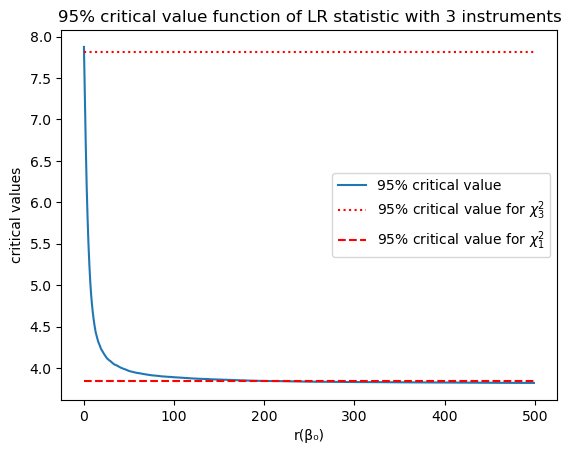

In [25]:
# --- GRAPHICAL OUTPUT ---

plt.plot(r_list, lr_cv_k3, label='95% critical value')  # Main line plot
plt.hlines(stats.chi2(k).ppf(0.95), 0, len(r_list), linestyles='dotted', color = 'red', label=r"95% critical value for $\chi^2_{3}$")  # Horizontal line for Chi2(3)
plt.hlines(stats.chi2(1).ppf(0.95), 0, len(r_list), linestyles='dashed', color = 'red', label=r"95% critical value for $\chi^2_{1}$")  # Horizontal line for Chi2(1)

plt.xlabel('r(β₀)')  # X-axis label
plt.ylabel('critical values')  # Y-axis label
plt.title('95% critical value function of LR statistic with 3 instruments')  # Title
plt.legend(loc='right')  # Show legend

# Export the plot as a png image with high dpi
plt.savefig('figure 4.png', dpi=800)

plt.show()  # Display the plot

# Question 5

## a)

In [26]:
## a) Using only nearc2 as an instrument, construct the 95% conÖdence set for the return on education using the 2SLS t-statistic and the AR statistic.
### Approach 1: using package
## first create matrix w
df['constant'] = 1

# Select the required columns and combine them into a matrix
columns_to_include = ['exper', 'exper2', 'south', 'smsa', 'race', 'constant']
w = df[columns_to_include].values

### regress y, x, z on W then obtain M_wy etc.
def partial_out(variable, W):
    """Regress variable on W and return residuals."""
    reg = LinearRegression(fit_intercept=False).fit(W, variable)
    residuals = variable - W @ reg.coef_.T
    return residuals

y=partial_out(df['wage'],w)
X=partial_out(df['ed'],w)
Z=partial_out(df['nearc2'],w)

alpha = 0.05
test_2sls = IV2SLS(y, X, Z).fit()
print(f'Confidence interval using 2SLS statistic: {test_2sls.conf_int(alpha)}')

KeyError: "['exper', 'exper2', 'south', 'smsa', 'race'] not in index"

In [ ]:
## Approach 2: Manual calculation

## a) Using only nearc2 as an instrument, construct the 95% conÖdence set for the return on education using the 2SLS t-statistic and the AR statistic.

## first create matrix w
df['constant'] = 1

# Select the required columns and combine them into a matrix
columns_to_include = ['exper', 'exper2', 'south', 'smsa', 'race', 'constant']
w = df[columns_to_include].values

### regress y, x, z on W then obtain M_wy etc.
def partial_out(variable, W):
    """Regress variable on W and return residuals."""
    reg = LinearRegression(fit_intercept=False).fit(W, variable)
    hat=W @ reg.coef_.T
    residuals = variable - W @ reg.coef_.T
    return residuals,hat

y=partial_out(df['wage'],w)[0]
x=partial_out(df['ed'],w)[0]
z=partial_out(df['nearc2'],w)[0]


### 2sls
def two_sls(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Estimate beta_hat
    beta_hat = np.sum(x_hat*y)/np.sum(x_hat**2)

    # Compute residuals from 2nd stage regression
    eps_hat = y - beta_hat*x

    # Compute standard error of beta_hat
    s_2 = np.sum(eps_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(x_hat**2))  # standard error of 2SLS estimator
    # np.sqrt (s_2 * np.sum(z*z) / np.sum((z*x)**2)) this formula is equivalent, but gives numerical instability

    # t statistic
    t_2sls=beta_hat/se_beta_hat

    #CI
    CI_upper=beta_hat-se_beta_hat*t.ppf(0.05 / 2, n-1)
    CI_lower=beta_hat-se_beta_hat*t.ppf(1 - 0.05 / 2, n-1)

    # Return fitted residuals
    return beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat,t_2sls,CI_lower,CI_upper

t_2sls=two_sls(y,x,z)[5]
t_CI_upper=two_sls(y,x,z)[-1]
t_CI_lower=two_sls(y,x,z)[-2]

print(f"The 95% confidence interval for 2SLS t-statistic is ({t_CI_lower},{t_CI_upper})")
print(f"The t-statistic for the 2SLS estimater is {t_2sls}")



In [ ]:
### anderson-rubin test more efficient calculation

def AR_stat (X,Y,Z,B_0):
    N = Z.shape[0]
    k = Z.shape[1]

    w=y - X*B_0
    numerator = partial_out(w,Z)[1].T@partial_out(w,Z)[1] / k
    denominator =partial_out(w,Z)[0].T@partial_out(w,Z)[0]  / (N - k)
    AR_statistic=numerator / denominator

    return AR_statistic

beta0=np.linspace(-3,3,100000) # possible values for beta

AR=[]
for beta in beta0:
    z=np.array(z).reshape(-1,1)
    AR.append(AR_stat(x, y, z, beta))
print(f"The critical value for 2SLS AR-statistic is {chi2.ppf(0.95,1)}")
critical_value=chi2.ppf(0.95,1)
beta_lower=beta0[AR>chi2.ppf(0.95,1)][0]
beta_upper=beta0[AR>chi2.ppf(0.95,1)][-1]
print(f"The 95% confidence interval for AR-statistic is (-infty,{beta_lower}),{beta_upper},+infty)")


In [ ]:
fig, ax = plt.subplots()
y_value = 3.8414588206941205
ax.plot(beta0,AR,color='cornflowerblue')  # Plot some data on the Axes.
ax.axhline(y=3.8414588206941205, color='darkorange', linestyle='--', label='AR = 3.8415')  # Add a horizontal line
ax.vlines(x=[beta_lower,beta_upper],ymin=0, ymax=3.841458820694120, color='sandybrown', linestyle='--', label=f'Lower bound = {beta_lower:.2f}')
# ax.vlines(x=beta_upper, ymin=0, ymax=3.841458820694120,color='green', linestyle='--', label=f'Upper bound = {beta_upper:.2f}')
# add the critical value annotation on the RHS of the y-axis
ax.annotate(f'Critical value: {y_value:.3f}', xy=(1, y_value), xycoords=('axes fraction', 'data'),
            xytext=(10, 0), textcoords='offset points',
            ha='left', va='center', color='darkorange',rotation=-90)
ax.set_ylim(0, None)
# add the shaded area (CI)
ax.fill_between((-3,beta_lower ), 0,y_value, color='sandybrown', alpha=0.2)
ax.fill_between((beta_upper,3 ), 0,y_value, color='sandybrown', alpha=0.2)
# add x-tick and xtick lable
ax.set_xticks([beta_lower,beta_upper])  # Add beta_lower to the ticks
ax.set_xticklabels([f'{beta_lower:.3f}',f'{beta_upper:.3f}'],color="sandybrown")

ax.set_title("Anderson-Rubin")
ax.set_xlabel(r"$\beta_0$")
ax.set_ylabel("AR statistics")
# plt.savefig('anderson_rubin_plot.png', dpi=800, bbox_inches='tight')  # Export as a PNG file with high resolution

plt.show()

### Question 5e

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import t, chi2

### 2SLS

# Load data
data = pd.read_csv('assignmentweakinstruments.csv')

# Extract relevant data
target = data.iloc[:, -1].values
all_instruments = data[['nearc2', 'nearc4', 'nearc4a']].values
x_star = data['ed'].values
N = data.shape[0]
w = np.c_[np.ones((N, 1)), data[['exper', 'exper2', 'south', 'smsa', 'race']].values]

# Calculate projections
Pw = w @ np.linalg.inv(w.T @ w) @ w.T
Z = all_instruments - Pw @ all_instruments
X = x_star.reshape(-1, 1) - Pw @ x_star.reshape(-1, 1)
y = target.reshape(-1, 1) - Pw @ target.reshape(-1, 1)

# 2SLS estimation
Pi_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ X
X_hat = Z @ Pi_hat
beta_hat_2sls = np.linalg.inv(X_hat.T @ X_hat) @ X_hat.T @ y

# Variance and t-statistic
residuals = y - X @ beta_hat_2sls
s2 = (residuals.T @ residuals) / (N - 1)
var_beta = s2 * np.linalg.inv(X.T @ Z @ np.linalg.inv(Z.T @ Z) @ Z.T @ X)
t_stat_a = beta_hat_2sls / np.sqrt(var_beta)

# Confidence interval
df = N - w.shape[1]
alpha = 0.05
t_critical = t.ppf(1 - alpha / 2, df)
margin_of_error = t_critical * np.sqrt(var_beta)
confidence_interval = (beta_hat_2sls - margin_of_error, beta_hat_2sls + margin_of_error)

print("95% Confidence Interval for t-statistic:", confidence_interval)


95% Confidence Interval for t-statistic: (array([[0.09074321]]), array([[0.2512426]]))


In [ ]:
### AR

# Define the grid of values for AR stat
#beta_grid = np.linspace(beta_hat_2sls - 0.5, beta_hat_2sls + 0.5, 1000)
beta_grid = np.linspace(beta_hat_2sls - 2, beta_hat_2sls + 2, 1000)

# Initialize arrays to store AR statistics and confidence set
AR_statistics = np.zeros_like(beta_grid)
confidence_set = []

# Define the projection matrix for Z
PZ = Z @ np.linalg.inv(Z.T @ Z) @ Z.T

# Define the number of instruments (k) as the number of columns in Z
k = Z.shape[1]

# Loop through the grid and calculate AR statistics
for i, beta_value in enumerate(beta_grid):
    beta_hat_2sls[0] = beta_value

    # Calculate the AR statistic
    num = (y - X @ beta_hat_2sls).T @ PZ @ (y - X @ beta_hat_2sls) / k
    denom = (y - X @ beta_hat_2sls).T @ (np.eye(N) - PZ) @ (y - X @ beta_hat_2sls) / (N - k)
    AR_stat = num / denom
    AR_statistics[i] = AR_stat

# Calculate the 95% critical value of the χ²(k) distribution
df_AR = k  # Degrees of freedom for the chi-squared distribution
alpha = 0.05
chi2_critical_value = chi2.ppf(1 - alpha, df_AR)

# Identify values of beta for which the AR statistic is less than the critical value
for i, beta_value in enumerate(beta_grid):
    if AR_statistics[i] < chi2_critical_value / k:
        confidence_set.append(beta_value)

# Print or use the confidence set as needed
print("95% Confidence Set for β:", np.min(confidence_set), np.max(confidence_set))


95% Confidence Set for β: 0.09709709709709702 0.3213213213213213


In [ ]:
# Question 5g

AR_min = np.min(AR_statistics)
print("Minimal value of AR statistic:", AR_min)
index = np.where(AR_statistics == AR_min)[0]
beta_grid_flat = beta_grid.flatten()
print("Corresponding beta:", beta_grid_flat[index])

critical_value_AR = chi2.ppf(1 - 0.05 , k)/3
print("Critical value:", critical_value_AR)


Minimal value of AR statistic: 0.8731184222951043
Corresponding beta: [0.18118118]
Critical value: 2.6049093010837265


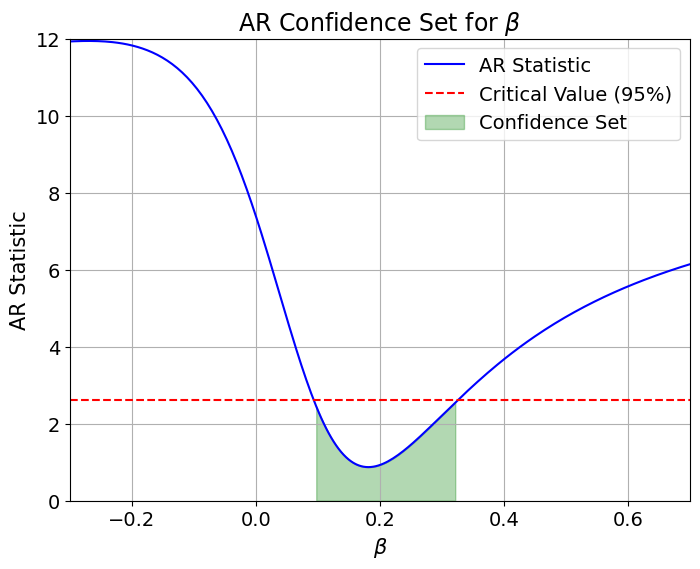

In [ ]:
import matplotlib.pyplot as plt

# Flatten beta_grid and AR_statistics
#beta_grid_flat = beta_grid.flatten()
AR_statistics_flat = AR_statistics.flatten()

# Define the confidence set boundaries
min_conf_beta = np.min(confidence_set)
max_conf_beta = np.max(confidence_set)

# Find where the AR statistic crosses the critical value
crossing_indices = (AR_statistics_flat < chi2_critical_value / k)
crossing_beta = beta_grid_flat[crossing_indices]

# Plot the AR statistics
plt.figure(figsize=(8, 6))
plt.plot(beta_grid_flat, AR_statistics_flat, label='AR Statistic', color='blue')
plt.axhline(y=chi2_critical_value / k, color='red', linestyle='--', label='Critical Value (95%)')

# Highlight the confidence set
plt.fill_between(beta_grid_flat, 0, AR_statistics_flat,
                 where=crossing_indices,
                 color='green', alpha=0.3, label='Confidence Set')

# Set font size for x-axis and y-axis tick values
plt.tick_params(axis='x', labelsize=14)  # X-axis font size
plt.tick_params(axis='y', labelsize=14)  # Y-axis font size
plt.ylim(0, 12)
plt.xlim(-0.3, 0.7)

# Add labels, legend, and title
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel('AR Statistic', fontsize=15)
plt.title(r'AR Confidence Set for $\beta$', fontsize=17)
plt.legend(fontsize=14)
plt.grid(True)

# Save the plot
#plt.savefig('AE2_5a1.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
from scipy.stats import chi2

### LM

# Define the grid of values for beta
#beta_grid = np.linspace(beta_hat_2sls - 1, beta_hat_2sls + 1, 1000)
beta_grid = np.linspace(-1, 1, 400)

# Initialize arrays to store AR statistics and confidence set
LM_statistics = np.zeros_like(beta_grid)
confidence_set = []

# Loop through the grid and calculate AR statistics
for i, beta_value in enumerate(beta_grid):
    # Set the current beta value
    beta_hat_2sls[0] = beta_value

    # Derive sigma_hat (sigma_eps_eps and sigma_eps_V)
    epsilon = y - X @ beta_hat_2sls  # Residuals
    sigma_eps_eps = (epsilon.T @ (np.eye(N) - PZ) @ epsilon) / (N - k)
    sigma_eps_V = (epsilon.T @ (np.eye(N) - PZ) @ X) / (N - k)

    # Calculate pi_tilde
    rho = sigma_eps_V / sigma_eps_eps
    pi_tilde = np.linalg.inv(Z.T @ Z) @ Z.T @ (X - epsilon @ rho)

    # Calculate projection matrix for Z @ pi_tilde
    Z_pi_tilde = Z @ pi_tilde

    P_Z_pi_tilde = Z_pi_tilde @ np.linalg.inv(Z_pi_tilde.T @ Z_pi_tilde) @ Z_pi_tilde.T

    # Calculate LM statistic
    LM_statistics[i] = (epsilon.T @ P_Z_pi_tilde @ epsilon) / sigma_eps_eps

# Calculate the 95% critical value of the χ²(k) distribution
df_LM = 1  # Degrees of freedom for the chi-squared distribution
alpha = 0.05
chi2_critical_value = chi2.ppf(1 - alpha, df_LM)

# Identify values of beta for which the AR statistic is less than the critical value
confidence_set = [
    beta_value for i, beta_value in enumerate(beta_grid) if LM_statistics[i] < chi2_critical_value
]

print("95% Confidence Set for β:", np.min(confidence_set), np.max(confidence_set))


<ipython-input-23-b0d3cad46791>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LM_statistics[i] = (epsilon.T @ P_Z_pi_tilde @ epsilon) / sigma_eps_eps


95% Confidence Set for β: -0.368421052631579 0.30325814536340845


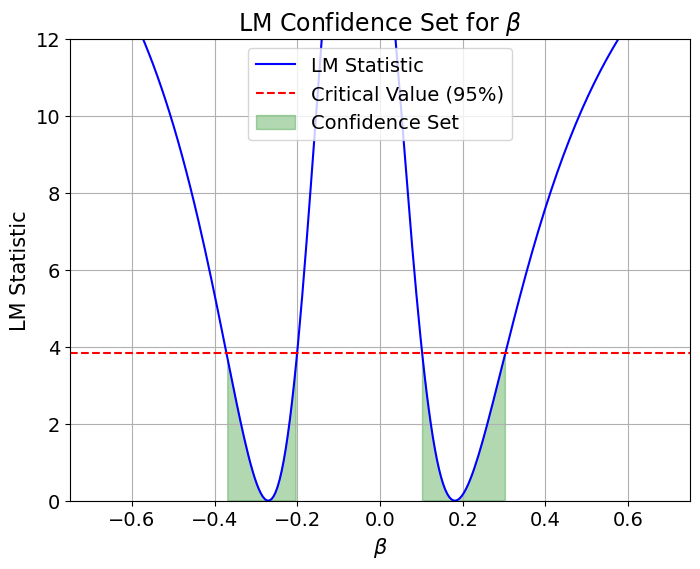

In [ ]:
import matplotlib.pyplot as plt

# Flatten beta_grid and AR_statistics
beta_grid_flat = beta_grid.flatten()
LM_statistics_flat = LM_statistics.flatten()

# Define the confidence set boundaries
min_conf_beta = np.min(confidence_set)
max_conf_beta = np.max(confidence_set)

# Find where the AR statistic crosses the critical value
crossing_indices = (LM_statistics_flat < chi2_critical_value)
crossing_beta = beta_grid_flat[crossing_indices]

# Plot the AR statistics
plt.figure(figsize=(8, 6))
plt.plot(beta_grid_flat, LM_statistics_flat, label='LM Statistic', color='blue')
plt.axhline(y=chi2_critical_value, color='red', linestyle='--', label='Critical Value (95%)')

# Highlight the confidence set
plt.fill_between(beta_grid_flat, 0, LM_statistics_flat,
                 where=crossing_indices,
                 color='green', alpha=0.3, label='Confidence Set')

# Set font size for x-axis and y-axis tick values
plt.tick_params(axis='x', labelsize=14)  # X-axis font size
plt.tick_params(axis='y', labelsize=14)  # Y-axis font size
plt.ylim(0, 12)
plt.xlim(-0.75, 0.75)

# Add labels, legend, and title
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel('LM Statistic', fontsize=15)
plt.title(r'LM Confidence Set for $\beta$', fontsize=17)
plt.legend(fontsize=14)
plt.grid(True)

# Save the plot
#plt.savefig('AE2_5a2.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
### LR

def simulate_likelihood_ratio(r_beta, num_simulations, num_grid_values):
    # Step 1: Specify a grid of values for r(beta_0)
    grid_values = np.linspace(0, num_grid_values-1, num_grid_values)

    # Step 2: Number of simulations S
    S = num_simulations

    # Container to store LR values
    LR_values = np.zeros((S, len(grid_values)))

    # Step 3: Simulation Steps
    for g, r_beta_g in enumerate(grid_values):
        for s in range(S):
            psi_1 = np.random.chisquare(1)
            psi_k1 = np.random.chisquare(k-1)  # Assuming k = 2 for simplicity

            # Compute LR(β_0)_s^g
            LR_values[s, g] = (0.5*((psi_k1 + psi_1 - r_beta_g) + np.sqrt(((psi_k1 + psi_1 + r_beta_g)**2 -4*r_beta_g*psi_k1))))

    # Step 4: Sorting
    sorted_LR_values = np.sort(LR_values, axis=0)

    # Step 5: Critical Value Calculation
    critical_value_index = int(0.95 * S) - 1
    critical_value = sorted_LR_values[critical_value_index, :]

    return critical_value

# Example usage
num_simulations = 100000
num_grid_values = 50
r_beta_0_critical_values = simulate_likelihood_ratio(1.0, num_simulations, num_grid_values)

critical_values_LR = r_beta_0_critical_values

# Define the grid of values for β
#beta_grid = np.linspace(start=0.05, stop=0.41, num=100)
#beta_grid = np.linspace(0, 1, 1001)
beta_grid = np.linspace(beta_hat_2sls - 2, beta_hat_2sls + 2, 1000)

# Initialize arrays to store LR statistics and confidence set
LR_statistics = np.zeros_like(beta_grid)
confidence_set = []

# Loop through the grid and calculate LR statistics
for i, beta_value in enumerate(beta_grid):
    # Set the current β value
    beta_hat_2sls[0] = beta_value

    # Calculate residuals and intermediate sigma terms
    epsilon = y - X @ beta_hat_2sls
    sigma_eps_eps = (epsilon.T @ (np.eye(N) - PZ) @ epsilon) / (N - k)
    sigma_eps_V = (epsilon.T @ (np.eye(N) - PZ) @ X) / (N - k)
    sigma_V_eps = (X.T @ (np.eye(N) - PZ) @ epsilon) / (N - k)
    sigma_hat_vv = (X.T @ (np.eye(N) - PZ) @ X) / (N - k)
    sigma_hat_vv_eps = sigma_hat_vv - ((sigma_V_eps * sigma_eps_V) / sigma_eps_eps)

    # Calculate pi_tilde
    rho = sigma_eps_V / sigma_eps_eps
    pi_tilde = np.linalg.inv(Z.T @ Z) @ Z.T @ (X - epsilon @ rho)

    # Calculate Z @ pi_tilde and its projection matrix
    Z_pi_tilde = Z @ pi_tilde
    if np.linalg.matrix_rank(Z_pi_tilde.T @ Z_pi_tilde) < Z_pi_tilde.shape[1]:
        LR_statistics[i] = np.inf  # Skip if the matrix is singular
        continue
    P_Z_pi_tilde = Z_pi_tilde @ np.linalg.inv(Z_pi_tilde.T @ Z_pi_tilde) @ Z_pi_tilde.T

    # Calculate LM statistics
    kAR_stat = (epsilon.T @ PZ @ epsilon) / sigma_eps_eps
    LM = (epsilon.T @ P_Z_pi_tilde @ epsilon) / sigma_eps_eps

    # Calculate r(β)
    r_beta_0 = (Z_pi_tilde.T @ Z_pi_tilde) / sigma_hat_vv_eps

    # Calculate LR statistics
    LR = 0.5 * (k * kAR_stat - r_beta_0 + np.sqrt((k * kAR_stat + r_beta_0) ** 2 - 4 * r_beta_0 * (k * kAR_stat - LM)))
    LR_statistics[i] = LR

    # Check if LR statistic is below the critical value
    critical_value = critical_values_LR[round(int(r_beta_0))]  # Replace with actual critical value logic
    if LR < critical_value:
        confidence_set.append(beta_value)

# Print the confidence set
print("95% Confidence Set for β:", np.min(confidence_set), np.max(confidence_set))



<ipython-input-25-a7296dc6b16f>:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  critical_value = critical_values_LR[round(int(r_beta_0))]  # Replace with actual critical value logic


95% Confidence Set for β: 0.11711711711711703 0.2732732732732732


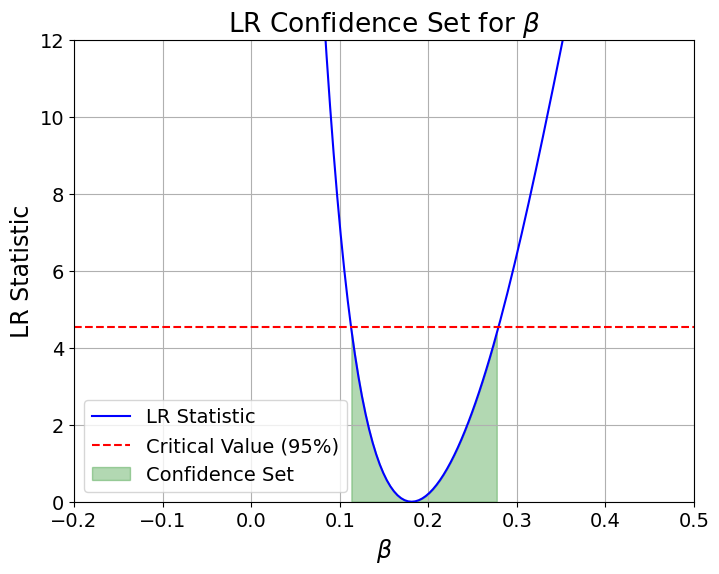

In [ ]:
import matplotlib.pyplot as plt

# Flatten beta_grid and AR_statistics
beta_grid_flat = beta_grid.flatten()
LR_statistics_flat = LR_statistics.flatten()

# Define the confidence set boundaries
min_conf_beta = np.min(confidence_set)
max_conf_beta = np.max(confidence_set)

# Find where the AR statistic crosses the critical value
crossing_indices = (LR_statistics_flat < critical_value)
crossing_beta = beta_grid_flat[crossing_indices]

# Plot the AR statistics
plt.figure(figsize=(8, 6))
plt.plot(beta_grid_flat, LR_statistics_flat, label='LR Statistic', color='blue')
plt.axhline(y=critical_value, color='red', linestyle='--', label='Critical Value (95%)')

# Highlight the confidence set
plt.fill_between(beta_grid_flat, 0, LR_statistics_flat,
                 where=crossing_indices,
                 color='green', alpha=0.3, label='Confidence Set')

# Set font size for x-axis and y-axis tick values
plt.tick_params(axis='x', labelsize=14)  # X-axis font size
plt.tick_params(axis='y', labelsize=14)  # Y-axis font size
plt.ylim(0, 12)
plt.xlim(-0.2, 0.5)

# Add labels, legend, and title
plt.xlabel(r'$\beta$', fontsize=17)
plt.ylabel('LR Statistic', fontsize=17)
plt.title(r'LR Confidence Set for $\beta$', fontsize=19)
plt.legend(fontsize=14)
plt.grid(True)

# Save the plot
#plt.savefig('AE2_5a3.png', dpi=300)

# Show the plot
plt.show()
